**Fáza 3 - strojové učenie**

Michaela Hanková, Martin Rudolf

50%:50%

cvičenie: piatok 10:00

dataset: 163

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import scipy.stats as stats
from matplotlib.pyplot import figure 
from sklearn.impute import SimpleImputer
from numpy import isnan
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import category_encoders as ce
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import set_config
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
plt.rcParams['figure.figsize'] = 9, 6
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

In [2]:
data_labor = pd.read_csv("163/labor.csv", sep='\t', index_col=0)
data_labor['smoker'] = data_labor['smoker'].str.replace('Y','yes')
data_labor['smoker'] = data_labor['smoker'].str.replace('N','no')
data_labor['relationship'] = data_labor['relationship'].str.replace('divoced','divorced')
data_labor = data_labor.drop_duplicates()

In [3]:
data_profiles = pd.read_csv(r"163/profiles.csv", sep='\t', index_col=0)
# v stĺpcoch address a residence boli v záznamoch znaky '\n' , nahradím tento znak medzerou
data_profiles['address'] = data_profiles['address'].replace(r'\s+|\\n', ' ', regex=True)
data_profiles['residence'] = data_profiles['residence'].replace(r'\s+|\\n', ' ', regex=True)
# nastavenie rovnakého formátu pre dátumy
data_profiles['birthdate'] = pd.to_datetime(data_profiles['birthdate'])
# upravenie hodnoty v stĺpci 'race' z blsck na Black, black na Black, white na White
data_profiles['race'] = data_profiles['race'].str.replace('blsck','Black')
data_profiles['race'] = data_profiles['race'].str.replace('black','Black')
data_profiles['race'] = data_profiles['race'].str.replace('white','White')

In [4]:
spojene_datasety = data_labor.set_index('ssn').join(data_profiles.set_index('ssn'), rsuffix = 'name')
spojene_datasety = spojene_datasety.drop(columns = 'namename', axis = 1)

Ako môžeme vidieť, najvyššiu hodnotu korelácie s premennou indicator má hematokrit.

In [5]:
spojene_datasety.corr()

,leukocyty,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
leukocyty,1.000000,0.004640,-0.014721,0.015860,-0.004818,-0.011178,0.002531,0.000989,-0.015768,-0.009489,0.007969,0.012035,-0.005183
hemoglobin,0.004640,1.000000,-0.025521,0.341538,-0.003252,0.016932,0.000555,-0.229272,-0.377629,-0.406118,0.000632,-0.002817,0.193101
trombocyty,-0.014721,-0.025521,1.000000,-0.013625,0.012614,0.008477,0.008704,0.006070,0.016667,0.007110,-0.021420,0.014990,-0.004625
indicator,0.015860,0.341538,-0.013625,1.000000,-0.062122,0.004941,0.000201,0.075600,-0.342863,-0.001359,-0.006138,-0.004004,-0.003483
alt,-0.004818,-0.003252,0.012614,-0.062122,1.000000,-0.000318,-0.004409,-0.106587,0.073943,0.066469,-0.017070,0.015463,0.447086
weight,-0.011178,0.016932,0.008477,0.004941,-0.000318,1.000000,-0.010877,0.011238,0.006388,0.014668,-0.002592,-0.011031,-0.005883
ast,0.002531,0.000555,0.008704,0.000201,-0.004409,-0.010877,1.000000,0.006996,0.010907,0.006823,0.007899,-0.014574,0.006656
alp,0.000989,-0.229272,0.006070,0.075600,-0.106587,0.011238,0.006996,1.000000,0.046733,0.134554,-0.011134,-0.001320,-0.190029
hematokrit,-0.015768,-0.377629,0.016667,-0.342863,0.073943,0.006388,0.010907,0.046733,1.000000,0.354859,0.007639,-0.003259,0.110563
hbver,-0.009489,-0.406118,0.007110,-0.001359,0.066469,0.014668,0.006823,0.134554,0.354859,1.000000,-0.025003,0.002978,-0.021696


Načítanie trénovacích a testovacích dát z fázy 2

In [6]:
training_data = pd.read_csv(r"163/vystupny_subor_faza2.csv", sep=',', index_col=0)
training_data

,alt,hbver,hematokrit,hemoglobin,blood_group_0,blood_group_1,blood_group_2,blood_group_3,indicator
ssn,,,,,,,,,
142-57-9305,-2.337903,0.011563,0.423914,1.792224,0,1,0,1,1.0
451-19-8635,2.064601,-1.319763,-0.728357,0.925073,0,1,1,0,1.0
657-99-0971,-0.180898,0.738461,0.629021,-0.779083,0,1,0,0,1.0
152-76-7044,0.308358,2.053148,-1.036412,0.311321,0,1,0,0,0.0
163-46-3919,0.623893,1.669422,-0.059511,-0.495611,0,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...
428-29-5802,0.144350,-0.692957,-0.609748,1.013546,0,1,1,0,0.0
632-59-2895,-2.200330,0.631409,1.067476,-1.865162,0,1,0,0,0.0
326-55-6791,-1.302864,-1.309283,-0.396730,0.275903,0,1,0,0,1.0


In [7]:
testing_data = pd.read_csv("163/testing_data.csv", sep=',', index_col=0)
testing_data

,alt,hbver,hematokrit,hemoglobin,blood_group_0,blood_group_1,blood_group_2,blood_group_3,indicator
ssn,,,,,,,,,
541-41-1830,-0.332961,-0.232545,0.721073,0.292310,1,0,0,0,0.0
878-03-3374,-0.882099,-0.154242,-1.262765,0.897784,1,0,0,0,0.0
361-64-5990,0.070131,0.761426,0.429344,0.499255,0,1,1,0,1.0
606-95-8130,-0.237267,-0.012340,0.732314,-0.478227,0,0,0,1,0.0
719-26-2815,0.421176,0.843501,0.640011,0.117417,0,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...
516-38-3288,-1.064675,-0.784496,-0.551049,-1.367680,0,1,1,0,1.0
236-65-6676,-0.090070,0.459898,-0.430227,-0.001574,0,0,1,0,1.0
648-21-4418,-0.035652,0.101854,0.921245,0.596117,1,0,0,0,1.0


Keďže nám vyšlo, že najvyššiu koreláciu s premennou indicator má hematokrit, zobrazíme si graf, aby sme videli, aká je hraničná hodnota pre chorých a zdravých ľudí. Podľa grafu to je 0

D:\IAU_projekt\env_name\lib\site-packages\seaborn\distributions.py:967: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\IAU_projekt\env_name\lib\site-packages\seaborn\distributions.py:1015: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
D:\IAU_projekt\env_name\lib\site-packages\seaborn\distributions.py:967: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\IAU_projekt\env_name\lib\site-packages\seaborn\distributions.py:1015: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


<AxesSubplot:xlabel='hematokrit', ylabel='Density'>

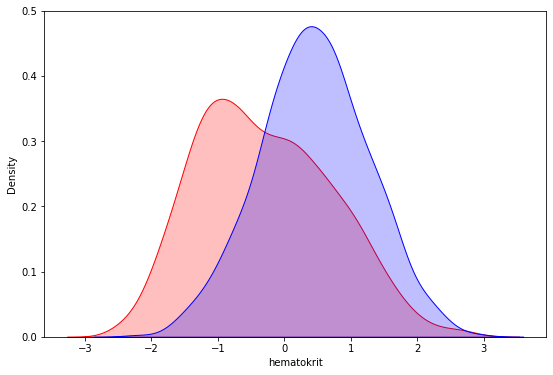

In [8]:
sns.kdeplot(training_data.loc[(training_data['indicator'] == 1.0), 'hematokrit'],
            color='r', shade=True, Label='chory')
  
sns.kdeplot(training_data.loc[(training_data['indicator'] == 0.0), 'hematokrit'],
            color='b', shade=True, Label='zdravy')

**1R implementácia**

Na základe hodnoty hematokritu prepíšeme indikátor na 1.0 (ak je hematokrit menší ako 0) alebo na 0.0

In [9]:
def singleRule(dataset):
    vysledok = pd.Series()
    pocet = 0
    for i, riadok in dataset.iterrows():
        if (riadok["indicator"] in [1.0, 0.0]):
            if (riadok["hematokrit"] < 0):
                vysledok = vysledok.append(pd.Series([1.0])) 
            elif (riadok["hematokrit"] >= 0):
                vysledok = vysledok.append(pd.Series([0.0])) 
    return vysledok

Do povodny_indikator uložím indikátory z testovacieho datasetu. Potom testovacie dáta pošlem do funkcie, ktorá prepíše
indikátory na základe toho, či je hematokrit väčší alebo menší ako 0. Ak je >=0, pacient by mal byť zdravý.

In [10]:
spravne = testing_data["indicator"].dropna()
predikcie = singleRule(testing_data)


C:\Users\hanko\AppData\Local\Temp/ipykernel_47572/4086370876.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vysledok = pd.Series()


Pomocou accuracy, precision a recall si vypíšeme úspešnosť nášho 1R

In [11]:
print(accuracy_score(spravne, predikcie))
print(precision_score(spravne, predikcie, average="macro"))
print(recall_score(spravne, predikcie, average="macro"))
print(classification_report(spravne,predikcie))


0.6343852013057671
0.6515610059284758
0.6679140844324382
              precision    recall  f1-score   support

         0.0       0.47      0.77      0.59       310
         1.0       0.83      0.56      0.67       609

    accuracy                           0.63       919
   macro avg       0.65      0.67      0.63       919
weighted avg       0.71      0.63      0.64       919



In [12]:
X_training = training_data.drop('indicator', axis = 'columns')
y_training = training_data['indicator']
X_testing = testing_data.drop('indicator', axis = 'columns')
y_testing = testing_data['indicator']
feature_names = list(training_data.dtypes.index.values)

#vytvorime klasifikator a natrenujeme ho s trenovacimi datami
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_training, y_training)

[Text(637.3706896551724, 489.24, 'hemoglobin <= -0.899\ngini = 0.455\nsamples = 2143\nvalue = [750, 1393]'),
 Text(264.5689655172414, 380.52000000000004, 'hematokrit <= -0.437\ngini = 0.413\nsamples = 394\nvalue = [279, 115]'),
 Text(96.20689655172414, 271.8, 'hematokrit <= -0.795\ngini = 0.111\nsamples = 51\nvalue = [3, 48]'),
 Text(48.10344827586207, 163.08000000000004, 'gini = 0.0\nsamples = 37\nvalue = [0, 37]'),
 Text(144.31034482758622, 163.08000000000004, 'hematokrit <= -0.765\ngini = 0.337\nsamples = 14\nvalue = [3, 11]'),
 Text(96.20689655172414, 54.360000000000014, '\n  (...)  \n'),
 Text(192.41379310344828, 54.360000000000014, '\n  (...)  \n'),
 Text(432.93103448275866, 271.8, 'hbver <= 1.403\ngini = 0.314\nsamples = 343\nvalue = [276, 67]'),
 Text(336.7241379310345, 163.08000000000004, 'hematokrit <= 2.52\ngini = 0.258\nsamples = 296\nvalue = [251, 45]'),
 Text(288.62068965517244, 54.360000000000014, '\n  (...)  \n'),
 Text(384.82758620689657, 54.360000000000014, '\n  (...)

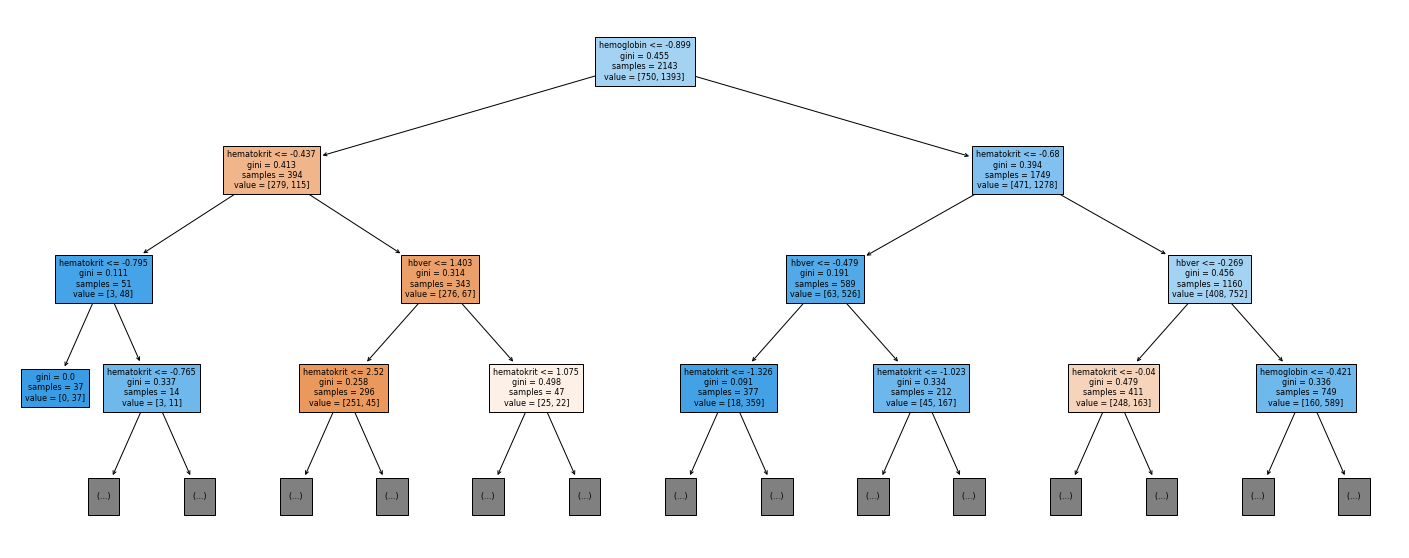

In [13]:
#vizualizacia modelu len do hlbky 3, hlbsie je problem vizualizovat kvoli komlexnosti modelu
fig = plt.figure(figsize=(25,10))
tree.plot_tree(clf, max_depth = 3, filled = True, feature_names=feature_names, fontsize = 8)

## Porovnanie 1R a DecisionTreeClassfier
Keď porovnáme náš implementovaný 1R klasifikátor s natrenovaným rozhodovacím stromom tak dôjdeme k záveru, že náš algoritmus zaostáva o viac ako 10%, čo nám potvrdzujú všetky pozorované metriky, accuracy, precision a recall. 
Tieto metriky vyhodnocujú úspešnosť na základe týchto formúl:
$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$
$Precision = \frac{TP}{TP+FP}$
$Recall = \frac{TP}{TP+FN}$

In [14]:
#vyskusame nas model na testovacich datach a pozrieme sa na uspesnost
y_pred = clf.predict(X_testing)

print("accuracy score je: %f" % accuracy_score(y_testing, y_pred))
print("precision score je: %f" % precision_score(y_testing, y_pred, average="macro"))
print("recall score je: %f" % recall_score(y_testing, y_pred, average="macro"))
print(classification_report(y_testing,y_pred))

accuracy score je: 0.761697
precision score je: 0.735033
recall score je: 0.744176
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.66       310
         1.0       0.84      0.80      0.82       609

    accuracy                           0.76       919
   macro avg       0.74      0.74      0.74       919
weighted avg       0.77      0.76      0.76       919



## Trénovanie klasifikátora strojového učenia a hyperparameter tunning
Najprv si vyextrahujeme názvy atribútov, ktoré rozdelíme na kategorické a numerické, aby sme si podľa nich mohli nastaviť pipeline. Potom si rozdelíme data na testovaciu a trénovaciu vzorku. Testovaciu vzorku použijeme až po experimentoch a hyperparameter tunningu. Experimenty vykonávame len na trénovacich dátach za asistencie K-fold cross validácie aby sme predišli pretrénovaniu. Ešte pred samotnými experimentami si nastavíme pipeline na metódy s ktorými si chceme predspracovať naše atribúty. Následne ak sme spokojní s natrénovaným modelom alebo už pomocou nastavovania hyperparametrov viac z neho nevieme vymačknuť, tak ho odtestujeme na testovacích dátach. 


In [15]:
# v num_data sú nevyškálované numerické dáta bez outlierov
num_data = pd.read_csv("163/numeric_data.csv", sep=',', index_col=0)
cat_data = pd.read_csv("163/categoric_data.csv", sep=',', index_col=0)
df = num_data.merge(cat_data, on='ssn')
df = df.drop('job', axis='columns')

In [16]:
#vyextrahujeme si numericke a kategoricke atributy aby sme si pre ne mohli neskor nastavit pipeline
cat_cols = list(df.dtypes[df.dtypes == 'object'].index.values)
num_cols = list(df.dtypes[df.dtypes != 'object'].index.values)
num_cols.remove('indicator')

for col in cat_cols:
    df[col] = df[col].astype('category')

X = df[df.columns.difference(['indicator'])]
y = df['indicator']
#rozdelime si data na trenovacie a tetovacie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Nastavenie hyperparametrov decision tree klasifikátoru 

**criterion** tento parameter meria kvalitu rozdelenia datasetu. Podporované hodnoty su string "gini" a "entropy". Štúdie hovoria že rozdiel medzi možnosťami tohto parametru nie sú preukázateľné na výkone, no v našm prípade sme zaznamenali lepšie výsledky s hodnotou entropy ktorá meria kvalitu rozdelenia logaritmickou funkciou preto môže byŤ výpoČet o čosi pomalší. 
### Gini: $Gini(E) = 1 - \sum_{j=1}^c p_j^2$
### Entropy: $H(E) = - \sum_{j=1}^c p_j log{}{p_j}$

**splitter** parameter je vlatne sposob akým sa budu rozdeľovať uzly v strome. String hodnotou tohto parametru je "random" alebo "best". Pri naŠích experimentoch sme sa zhodli na parametri hodnote "best" z dôvodu lešíeho výkonu o niekoľko stotín. Tento parameter používa random uniform function a na jej vstupe prijíma mean_feature_value max_feature_value a random_state, všetky tieto vstupne parametre su taktiež hyperparametramy celého klasifikátora.

**max_depth** s týmto parametrom môžme bojovať s overfittingom alebo s underfittingom. Hodnotou tohto parametra je celočíselná hodnota alebo príznak None. Ak máme pocit že dochádza k overfittingu tak zredukujeme hodnotu tohto parametra, no ak dochádza k underfittingu tak naopak boostneme túto hodnotu.

**min_samples_split** hovorí o minimapnom pocte vzoriek v uzle. Týmto parametrom vieme kontrolovaŤ taktiež over/underfitting, kde vysoké hodnoty môžu spôsobovaŤ underfitting. Niektoré štúdia tvrdia že ideálne hodnoty pre tento parameter sú medzi 1 až 40. Pri naších experimentoch sme došli k hodnote 26, pri ktorej sme generovali najlepšie výsledky.

**min_samples_leaf** definuje minimálny počet vzoriek potrebných na uzle reprezentujúcom list stromu. Tým že na každom liste bude viac než jeden element viem takisto predísŤ overfittingu. Štúdia hovorí že tento parameter spolu s hyperparametrom **min_samples_split** majú najväčší vplyv na úspešnosť modelu, čo sa nám aj potvrdilo po experimentoch s týmito hyperparametrami, ktoré nám boostli úspešnosť približne o 5%. 

**max_features** hodnotami sú int, float, string (auto, sqrt, log2, None), ktoré hovoria o počte atribútov potrebných na najlepšie rozdelenie. Pri našom pozorovaní sme zistili, že čím zväčšujeme číslo tohto parametru tým máme aj lepšiu úspešnosť modelu. Najlepšie výsledky sme ale odpozorovali pre deafultnú hodnotu tohto parametru teda None.

**random_state** požijeme celočíselnú hodnotu ak chcem určíť od akého základu sa odpichne generátor náhodných čísel s ktorým pracuje. Obľúbenou hodnotou pre tento parameter je 42, no po niekoľkých experimentoch s týmto parametrom sme ostali pri defaultnej hodnote, keďže nám generovala najväčší úspech modelu.

In [17]:
X = df[df.columns.difference(['indicator'])]
y = df['indicator']
#rozdelíme si data na trenovacie a testovacie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Pomocou GridSearch vyskúšame nájsť najvhodnejšie hyperparametre. Vyšlo nám, že máme použiť:
- entropy
- max_depth 6
- min_samples_leaf 2
- min_samples_split 26

In [22]:
criterion = ['gini', 'entropy']
max_depth = range(1, 20)
min_samples_split = range(1, 40) 
min_samples_leaf = range(1,40) 

hyper = dict(criterion = criterion, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )

gs = GridSearchCV(tree.DecisionTreeClassifier(), hyper, cv=5, verbose=1, n_jobs=-1)

best = gs.fit(X_training, y_training)
print(best)

Fitting 5 folds for each of 57798 candidates, totalling 288990 fits


D:\IAU_projekt\env_name\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7410 fits failed out of a total of 288990.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7410 fits failed with the following error:
Traceback (most recent call last):
  File "D:\IAU_projekt\env_name\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\IAU_projekt\env_name\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "D:\IAU_projekt\env_name\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 40),
                         'min_samples_split': range(1, 40)},
             verbose=1)


D:\IAU_projekt\env_name\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.68781452 0.68781452 ... 0.81150361 0.81150361 0.81150361]
  warnings.warn(


Najlepšie parametre podľa grid search sú nasledovné:

In [23]:
best.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 26}

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

Vytvoríme si prvú pipeline

In [24]:
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

column_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical, num_cols),
        ('cat', OneHotEncoder(), cat_cols)])

clf = Pipeline(steps=[('preprocessor', column_preprocessor),
                      ('classifier', tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6, min_samples_split=26, min_samples_leaf=2, 
                                                                 min_weight_fraction_leaf=0, max_features=None, random_state=None))])

In [25]:
set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['leukocyty', 'hemoglobin',
                                                   'trombocyty', 'alt', 'ast',
                                                   'hematokrit', 'hbver',
                                                   'etytr', 'er-cv',
                                                   'erytrocyty', 'smoker',
                                                   'sex']),
                                                 ('cat', OneHotEncoder(),
                                                  ['relationship',
                                                   'blood_group', 'race'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                        min_samples_leaf=2,
                                        min_samples_split=26,
                                        min_weight_fraction_leaf=0))])

In [26]:
clf_model = clf.fit(X_train, y_train)

In [27]:
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf_model, X_train, y_train, cv=5, scoring=scoring)

print("test accuracy score je: %f" % scores['test_accuracy'].mean())
print("test precision score je: %f" % scores['test_precision_macro'].mean())
print("recall score je: %f" % scores['test_recall_macro'].mean())

test accuracy score je: 0.816156
test precision score je: 0.804168
recall score je: 0.779568


In [28]:
y_pred = clf_model.predict(X_test)

accuracy score je: 0.835691
precision score je: 0.822314
recall score je: 0.817303
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.77       328
         1.0       0.87      0.88      0.87       591

    accuracy                           0.84       919
   macro avg       0.82      0.82      0.82       919
weighted avg       0.83      0.84      0.84       919



D:\IAU_projekt\env_name\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


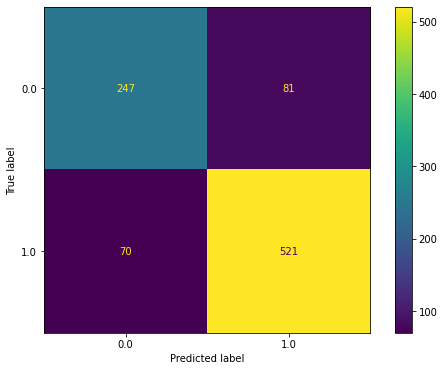

In [29]:
print("accuracy score je: %f" % accuracy_score(y_test, y_pred))
print("precision score je: %f" % precision_score(y_test, y_pred, average="macro"))
print("recall score je: %f" % recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test,y_pred))
plot_confusion_matrix(clf_model, X_test, y_test)

Teraz vyskúšame dať do pipeline numerické dáta bez odstránených outlierov

In [30]:
# v data_outlier sú teraz nevyškálované numerické dáta s outliermi
data_outlier = pd.read_csv("163/outlier_data.csv", sep=',', index_col=0)
cat_data = pd.read_csv("163/categoric_data.csv", sep=',', index_col=0)
df = data_outlier.merge(cat_data, on='ssn')
df = df.drop('job', axis='columns')

In [31]:
#vyextrahujeme si numericke a kategoricke atributy aby sme si pre ne mohli neskor nastavit pipeline
cat_cols = list(df.dtypes[df.dtypes == 'object'].index.values)
num_cols = list(df.dtypes[df.dtypes != 'object'].index.values)
num_cols.remove('indicator')

for col in cat_cols:
    df[col] = df[col].astype('category')

X = df[df.columns.difference(['indicator'])]
y = df['indicator']
#rozdelime si data na trenovacie a testovacie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

column_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical, num_cols),
        ('cat', OneHotEncoder(), cat_cols)])

clf = Pipeline(steps=[('preprocessor', column_preprocessor),
                      ('classifier', tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6, min_samples_split=26, min_samples_leaf=2, 
                                                                 min_weight_fraction_leaf=0, max_features=None, random_state=None))])

In [33]:
clf_model = clf.fit(X_train, y_train)

In [34]:
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf_model, X_train, y_train, cv=5, scoring=scoring)

print("test accuracy score je: %f" % scores['test_accuracy'].mean())
print("test precision score je: %f" % scores['test_precision_macro'].mean())
print("recall score je: %f" % scores['test_recall_macro'].mean())

test accuracy score je: 0.820767
test precision score je: 0.807243
recall score je: 0.784724


In [35]:
y_pred = clf_model.predict(X_test)

Zmeníme stratégiu simple imputeru na mean a scaler na MinMaxScaler

accuracy score je: 0.818675
precision score je: 0.807483
recall score je: 0.795826
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74       336
         1.0       0.84      0.88      0.86       585

    accuracy                           0.82       921
   macro avg       0.81      0.80      0.80       921
weighted avg       0.82      0.82      0.82       921



D:\IAU_projekt\env_name\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


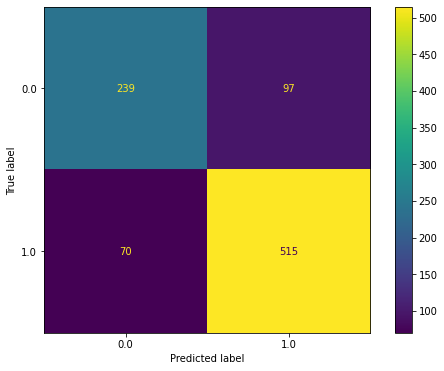

In [36]:
print("accuracy score je: %f" % accuracy_score(y_test, y_pred))
print("precision score je: %f" % precision_score(y_test, y_pred, average="macro"))
print("recall score je: %f" % recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test,y_pred))
plot_confusion_matrix(clf_model, X_test, y_test)

V nasledujúcej tabuľke sú zobrazené výsledky pre viaceré kombinácie škálovania a imputeru z pipeline. Pri hodnote median je najlepší výsledok true positive a true negative (dávajú súčet 768), ale majú horšie accuracy skóre, aj keď nie nejak výrazne. Hodnoty skóre sú pri MinMax a Standard škálovaní rovnaké.

Pri hodnote mean v imputeri sú výsledky pre žiadne škálovanie rovnako dobré ako pre Standard škálovanie. MinMax Scaler má o niečo horšie skóre.

Skratky znamenajú nasledovné:
- AS: accuracy score
- PS: precission score
- RS: recall score
- TP: true positive
- TN: true negative
- FP: false positive
- FN: false negative

| Imputer | Score | Scaler   |          |          |
|---------|-------|----------|----------|----------|
|         |       | MinMax   | Standard | None     |
|  Median | AS    | 0.816623 | 0.816156 | 0.816156 |
|         | PS    | 0.804713 | 0.804168 | 0.804168 |
|         | RS    | 0.779923 | 0.779568 | 0.779568 |
|         | TP    | 521      | 521      | 524      |
|         | TN    | 247      | 247      | 247      |
|         | FP    | 81       | 81       | 81       |
|         | FN    | 70       | 70       | 67       |
| Mean    | AS    | 0.816156 | 0.816623 | 0.816623 |
|         | PS    | 0.804168 | 0.804713 | 0.804713 |
|         | RS    | 0.779568 | 0.779923 | 0.779923 |
|         | TP    | 521      | 521      | 521      |
|         | TN    | 247      | 247      | 247      |
|         | FP    | 81       | 81       | 81       |
|         | FN    | 70       | 70       | 70       |

V ďalšej tabuľke je zobrazené skóre pre dáta s outliermi. Celkové hodnoty true positive a true negative sú o 13 nižšie ako hodnoty bez outlierov, tieto hodnoty dávajú súčet 755. Pre hodnoty median je najlepší scaler MinMax, pre hodnoty mean je to Standard scaler.
Ďalej si môžeme všimnúť, že výsledky accuracy, precission aj recall score sú vyššie u hodnôt s outliermi

| Imputer | Score | Scaler   |          |          |
|---------|-------|----------|----------|----------|
|         |       | MinMax   | Standard | None     |
|  Median | AS    | 0.819761 | 0.819834 | 0.818904 |
|         | PS    | 0.808868 | 0.805742 | 0.804513 |
|         | RS    | 0.796680 | 0.784020 | 0.782979 |
|         | TP    | 516      | 516      | 515      |
|         | TN    | 239      | 239      | 239      |
|         | FP    | 97       | 97       | 97       |
|         | FN    | 69       | 69       | 70       |
| Mean    | AS    | 0.820301 | 0.820767 | 0.819761 |
|         | PS    | 0.806547 | 0.807243 | 0.808868 |
|         | RS    | 0.784034 | 0.784724 | 0.784034 |
|         | TP    | 516      | 515      | 516      |
|         | TN    | 239      | 239      | 239      |
|         | FP    | 97       | 97       | 97       |
|         | FN    | 69       | 70       | 69       |